# Classifying Audio Using CNN

Classifying toxic and non-toxic speech using a VGG-19 inspired CNN.
___
Abhay Jolly | ajolly@sfu.ca\
Harry Preet Singh | hps1@sfu.ca\
Karan Pathania | kpathani@sfu.ca\
Neil Mukesh Shah | nmshah@sfu.ca
___
CMPT 419, Spring 2022\
Simon Fraser University

# 0. Preprocessing

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Ensure tensorflow version 2.x
%tensorflow_version 2.x

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout

# Set project directory
PROJECT_DIR = '/content/drive/MyDrive/CMPT 419 Project'

# 1. Preparing data

First of all, we load the audio mel-spectrograms using Keras' `image_dataset_from_directory` method. We use a `75-25` split for training and validation data, and we have a testing dataset to test our model on.

In [ ]:
# Required constants
N_CLASSES = 2
N_CHANNELS = 3
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
VALIDATION_SPLIT = 0.25
COLOR_MODE = 'rgb'
LABELS = 'inferred'
LABEL_MODE = 'int'
CLASS_NAMES = ['toxic', 'nontoxic']
AUDIO_DIR = os.path.join(PROJECT_DIR, 'audio_dataset', 'spectrogram_mel_split')

# Make a dataset containing the training spectrograms
print('Training dataset:')
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    directory=os.path.join(AUDIO_DIR, 'train'),
    shuffle=True,
    color_mode=COLOR_MODE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='training', 
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    seed=42)

# Make a dataset containing the validation spectrograms
print('\nValidation dataset:')
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    directory=os.path.join(AUDIO_DIR, 'train'),
    shuffle=True,
    color_mode=COLOR_MODE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='validation',
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    seed=42)

# Make a dataset containing the testing spectrograms
print('\nTesting dataset:')
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size=BATCH_SIZE,
    directory=os.path.join(AUDIO_DIR, 'test'),
    shuffle=False,
    color_mode=COLOR_MODE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    seed=42)

Training dataset:
Found 368 files belonging to 2 classes.
Using 276 files for training.

Validation dataset:
Found 368 files belonging to 2 classes.
Using 92 files for validation.

Testing dataset:
Found 123 files belonging to 2 classes.


Visualizing a few mel-spectrograms and their associated labels:

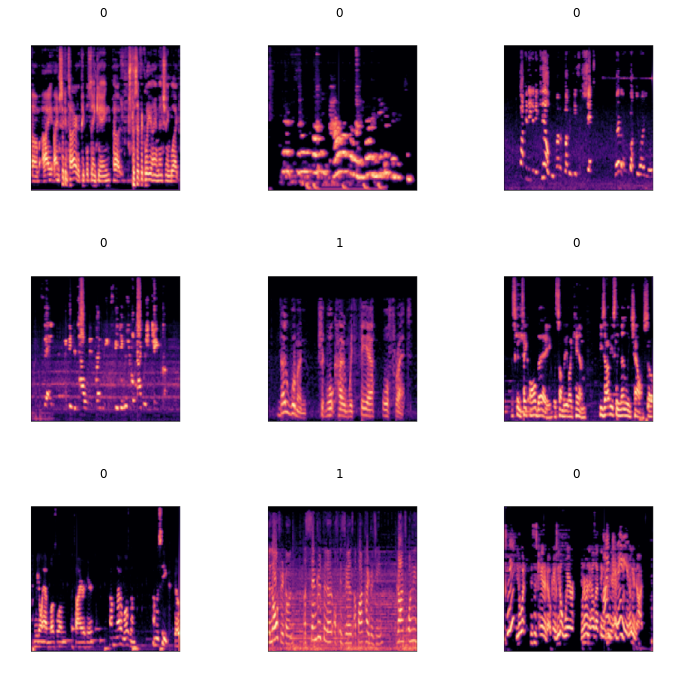

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(int(labels[i]))
        plt.axis('off')
plt.show()

As we can see above, the mel-spectrograms for toxic and non-toxic labels have a distinct structure, so we expect our CNN to be able to perform well.

# 2. CNN Model

In [ ]:
####################
# Create CNN model #
####################

model = Sequential(name='Audio_CNN')

model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation='softmax'))

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "Audio_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                     

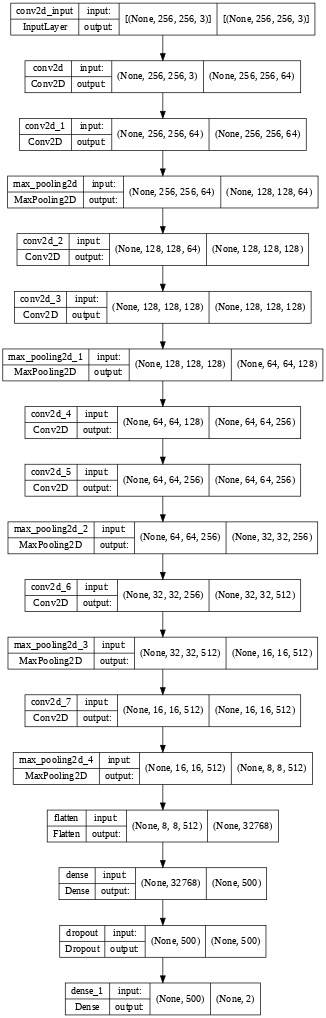

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model, '{}.png'.format(model.name), show_shapes=True, dpi =50)

In [ ]:
# Train model for N_EPOCHS and capture the history
N_EPOCHS = 20

history = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=valid_dataset)

Epoch 1/20
9/9 [==============================] - 56s 5s/step - loss: 100.2868 - accuracy: 0.4674 - val_loss: 0.7185 - val_accuracy: 0.5435
Epoch 2/20
9/9 [==============================] - 9s 877ms/step - loss: 0.7115 - accuracy: 0.5036 - val_loss: 0.6928 - val_accuracy: 0.4565
Epoch 3/20
9/9 [==============================] - 9s 878ms/step - loss: 0.6802 - accuracy: 0.5761 - val_loss: 0.6061 - val_accuracy: 0.7935
Epoch 4/20
9/9 [==============================] - 9s 908ms/step - loss: 0.6429 - accuracy: 0.6739 - val_loss: 0.5773 - val_accuracy: 0.6739
Epoch 5/20
9/9 [==============================] - 10s 913ms/step - loss: 0.5620 - accuracy: 0.6920 - val_loss: 0.4214 - val_accuracy: 0.8261
Epoch 6/20
9/9 [==============================] - 9s 880ms/step - loss: 0.5406 - accuracy: 0.6920 - val_loss: 0.4802 - val_accuracy: 0.7826
Epoch 7/20
9/9 [==============================] - 10s 880ms/step - loss: 0.4834 - accuracy: 0.7899 - val_loss: 0.3983 - val_accuracy: 0.8370
Epoch 8/20
9/9 [==

In [ ]:
# Save the model if needed
# model.save(filepath="/content/drive/MyDrive/CMPT 419 Project/saved_models/cnn/c4")

# 3. Evaluation

## 3.1 Training evaluation

We visualize some metrics during our model training.

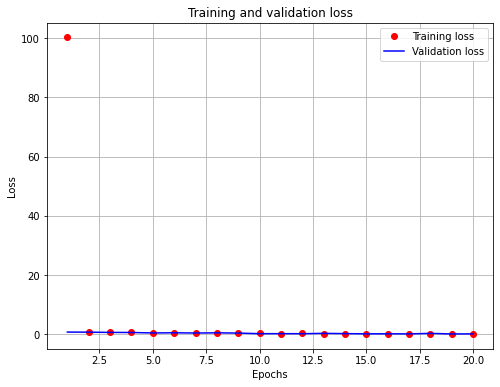

In [ ]:
# Plot the loss curves for training and validation
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, N_EPOCHS + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'bo', label='Training loss', color='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

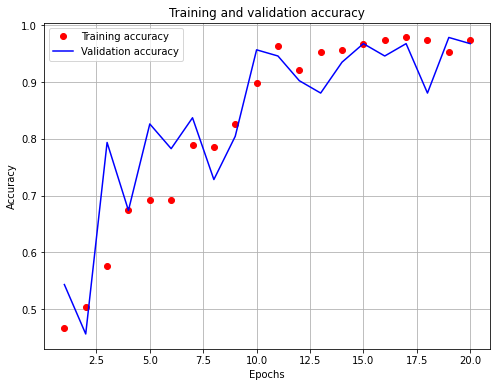

In [ ]:
# Plot the accuracy curves for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, N_EPOCHS + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'bo', label='Training accuracy', color='red')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

## 3.2 Testing evaluation

Now we will evaluate some metrics for our model with our never seen before testing dataset.

In [ ]:
# Compute loss and accuracy for our testing dataset
evaluations = model.evaluate(test_dataset, verbose=1, return_dict=True)

print('Testing loss: {0:.6f}'.format(evaluations['loss']))
print('Testing accuracy: {0:.6f}'.format(evaluations['accuracy']))

4/4 [==============================] - 2s 387ms/step - loss: 0.1866 - accuracy: 0.9350
Testing loss: 0.186567
Testing accuracy: 0.934959


In [ ]:
# Extract true and predicted labels

y_true = [l for _, l in test_dataset.unbatch().as_numpy_iterator()]
y_pred = np.argmax(model.predict(test_dataset), axis=1)

Classification Report:
               precision    recall  f1-score   support

       toxic       0.98      0.88      0.93        60
    nontoxic       0.90      0.98      0.94        63

    accuracy                           0.93       123
   macro avg       0.94      0.93      0.93       123
weighted avg       0.94      0.93      0.93       123

Confusion Matrix:



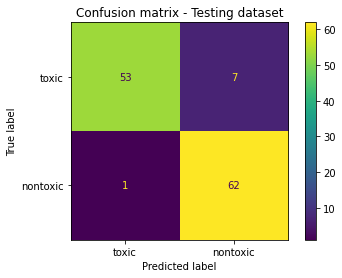

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(f'Classification Report:\n {classification_report(y_true, y_pred, target_names=CLASS_NAMES)}')

print(f'Confusion Matrix:\n')
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
cmd.plot()
plt.title('Confusion matrix - Testing dataset')
plt.show()

# References

- https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn
- https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-keras-model.md